# Anomaly Detection Data Preprocessing
## 0. Prerequisites
### Operating System
If you are using Mac OS, Linux, or WSL on Windows, skip to **Python Package Dependencies**.

Otherwise, follow the steps in [Anaconda_setup.ipynb](https://github.com/451488975/Anaconda_Setup) to set up WSL on Windows. Since WSL currently does not have GPU support, follow the steps in the tutorial labelled with "w/o NVIDIA GPU."
### Python Package Dependencies
Install the following dependencies:
* numpy
* matplotlib
* pandas
* tqdm
* h5py
* pyjet (not supported on Windows)

If you have Anaconda, first try installing them via Anaconda (make sure you're in the right environment!) by running `conda install [package name]` in terminal. If the package is not found by Anaconda, install with pip by running `pip install [package name]` in terminal.
### Data
We will be working with the [LHCO2020 R&D Dataset](https://zenodo.org/record/3832254#.X9VHi9hKguU). Download `events_anomalydetection.h5` from the link.


In [1]:
# Load all our modules

import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event

## 1. Loading Data
### Reading Data
Our data is stored as pandas dataframes in the compressed `.h5` file format. Since it's a large dataset, we can't read it in its entirety because it will likely exceed our RAM capacity. For the purposes of feature study, we do not need to read the entire dataset.

In [2]:
# Replace this variable with your relative path to datafile
datapath = "zenodo-data/events_anomalydetection.h5"

size = 110000
df = pd.read_hdf(datapath, stop = size) # The amount of data loaded can be changed depending on your hardware capabilities
print("Shape: " + str(df.shape))
print("Memory usage in GB:", round(sum(df.memory_usage(deep=True)) / (1024**3), 3))

Shape: (110000, 2101)
Memory usage in GB: 1.723


### Understanding Data
The data is described on the [Zenodo site](https://zenodo.org/record/3832254#.X9VHi9hKguU). In essence, each row corresponds to an event, which is either signal (W'->X+Y) or background QCD dijet.

The shape of the original dataset is `(1100000,2101)`. There are 1M background rows and 100k signal rows. The last column contains a single bit that indicates (for the purpose of R&D) `0` if the row is background and `1` if the row is signal.

Each row consists of up to 700 massless final-state, charged, hadronic particles recorded in `(pT,eta,phi)` triplets. Most rows don't have 700 non-trivial particles, and have instead been zero-padded up to 700 triplets.

The signal event consists of a hypothetical hadron W' with rest mass 3.5 TeV decaying into hypothetical hadrons X and Y with rest masses 500 GeV and 100 GeV, respectively. We expect the W' to be non-relativistic in the lab frame. We expect X to have total energy 1785 GeV and Y to have total energy 1716 GeV. Optionally, you can view the [derivation](https://www.overleaf.com/read/mpmgzzdcsyxz
).

X and Y then decay into two quarks each: X->qq, Y->qq. Since X and Y are relativistic, the quarks will be part of the same jet; that is, the signal event consists of two jets, one associated with X and one associated with Y. Each one of those jets will have two-pronged substructure, which we can see later by studying the tau2/tau1 feature.

In [3]:
# Observe the following about the data:
# pT columns are always positive
# Zero-padding is evident at the end
# Last column (index 2100) is the signal bit
# Signal and background are randomly shuffled within the data
df

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,0.317196,-1.894180,-1.489130,0.471456,-1.038607,1.712092,2.688182,-0.976232,2.883202,8.333219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109996,0.409338,-0.856824,-0.760231,0.783748,-2.152059,-0.545356,0.443872,-1.387182,2.604052,0.302948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109997,0.438333,-0.588083,2.878122,0.885400,-1.378334,0.572044,1.570132,-1.379626,0.320418,19.972057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109998,0.607581,-2.149287,-0.991910,0.473555,-1.655964,-1.247999,0.486681,-1.937636,-1.309540,1.827337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Split the data based on the signal bit and discard the flag column
df_bg = df[df[2100] == 0.0].iloc[:,:-1].reset_index(drop = True)
df_s = df[df[2100] == 1.0].iloc[:,:-1].reset_index(drop = True)
df = df.iloc[:,:-1]

In [5]:
print("Background shape: " + str(df_bg.shape))
print("Signal shape: " + str(df_s.shape))
print("Percent of signal in data: " + str(round(df_s.shape[0] / df.shape[0] * 100, 2)) + "%")

Background shape: (100006, 2100)
Signal shape: (9994, 2100)
Percent of signal in data: 9.09%


## 2. Cluster Jets
The goal is to cluster each row into two jets to reflect the W'->X,Y structure of the signal.

In [6]:
# Transposing df makes rows correspond to low-level features and columns correspond to events
events_combined = df.T
events_bg = df_bg.T
events_s = df_s.T

We'll cluster jets using the anti-kT algorithm in [pyjet](https://pypi.org/project/pyjet/) with a fat-jet radius of R=1.0. Then, we'll save lists of the leading and subleading jets for each event as PseudoJet objects. Later, we can call various attributes of the PseudoJet objects, like `pt`, `eta`, `phi`, `mass`, and `e`. We can also call methods like `constituents()`.

In [7]:
leadjets = {
    'bg': [],
    's': []
}
subleadjets = {
    'bg': [],
    's': []
}

def cluster_jets(dataframe, name):
    for i in tqdm(range(dataframe.shape[1])):
        # Collect (pT,eta,phi) of particles in event i with pT != 0
        pseudojets_input = np.zeros(len([x for x in dataframe[i][::3] if x > 0]), dtype = DTYPE_PTEPM)
        for j in range(700):
            if dataframe[i][j*3] > 0:
                pseudojets_input[j]['pT'] = dataframe[i][j*3]
                pseudojets_input[j]['eta'] = dataframe[i][j*3 + 1]
                pseudojets_input[j]['phi'] = dataframe[i][j*3 + 2]
            else:
                break

        sequence = cluster(pseudojets_input, R = 1.0, p = -1) # p = -1 corresponds to anti-kT
        jets = sequence.inclusive_jets(ptmin = 1200) # pT > 1.2 TeV

        if len(jets) < 2:
            continue
        
        leadjets[name] += [jets[0]]
        subleadjets[name] += [jets[1]]

In [8]:
cluster_jets(events_bg, 'bg')
cluster_jets(events_s, 's')

100%|██████████| 9994/9994 [00:51<00:00, 193.73it/s]


We now have four arrays of PseudoJet objects. Let's look at the lengths:

In [9]:
print("Background leading jets:", len(leadjets['bg']))
print("Background subleading jets:", len(subleadjets['bg']))
print("Signal leading jets:", len(leadjets['s']))
print("Signal subleading jets:", len(subleadjets['s']))
print("Events not clustered:", size - len(leadjets['bg']) - len(leadjets['s']))

Background leading jets: 62085
Background subleading jets: 62085
Signal leading jets: 9336
Signal subleading jets: 9336
Events not clustered: 38579


## 3. Plot Features
### Jet Masses

In [10]:
bg_lead_mass = [leadjets['bg'][x].mass for x in range(len(leadjets['bg']))]
bg_sublead_mass = [subleadjets['bg'][x].mass for x in range(len(subleadjets['bg']))]
s_lead_mass = [leadjets['s'][x].mass for x in range(len(leadjets['s']))]
s_sublead_mass = [subleadjets['s'][x].mass for x in range(len(subleadjets['s']))]

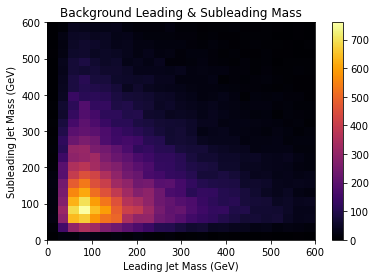

In [11]:
plt.title("Background Leading & Subleading Mass")
plt.ylabel("Subleading Jet Mass (GeV)")
plt.xlabel("Leading Jet Mass (GeV)")
plt.hist2d(bg_lead_mass, bg_sublead_mass, bins = 25, range = [[0,600],[0,600]], cmap = 'inferno')
plt.colorbar()
plt.show()

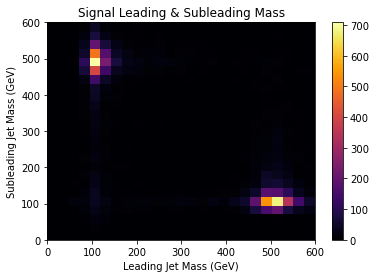

In [12]:
plt.title("Signal Leading & Subleading Mass")
plt.ylabel("Subleading Jet Mass (GeV)")
plt.xlabel("Leading Jet Mass (GeV)")
plt.hist2d(s_lead_mass, s_sublead_mass, bins = 25, range = [[0,600],[0,600]], cmap = 'inferno')
plt.colorbar()
plt.show()

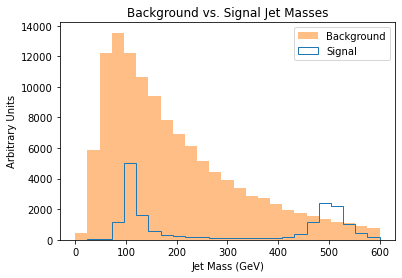

In [13]:
plt.title("Background vs. Signal Jet Masses")
plt.ylabel("Arbitrary Units")
plt.xlabel("Jet Mass (GeV)")
plt.hist(bg_lead_mass + bg_sublead_mass, bins = 25, range = (0, 600), color = "tab:orange", alpha = 0.5, label = "Background")
plt.hist(s_lead_mass + s_sublead_mass, bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "Signal")
plt.legend()
plt.show()

### Exercise: Jet Energies
As an exercise, repeat the plotting for the jet energy. The jet energy is an attribute of PseudoJet and can be accessed as `PseudoJet.e`, very similar to jet mass.

In [14]:
bg_lead_e = [leadjets['bg'][x].e for x in range(len(leadjets['bg']))]
bg_sublead_e = [subleadjets['bg'][x].e for x in range(len(subleadjets['bg']))]
s_lead_e = [leadjets['s'][x].e for x in range(len(leadjets['s']))]
s_sublead_e = [subleadjets['s'][x].e for x in range(len(subleadjets['s']))]

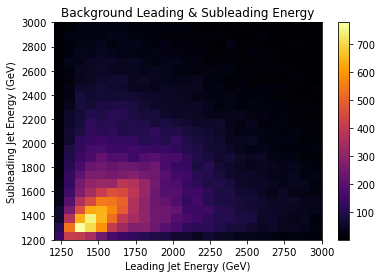

In [15]:
plt.title("Background Leading & Subleading Energy")
plt.ylabel("Subleading Jet Energy (GeV)")
plt.xlabel("Leading Jet Energy (GeV)")
plt.hist2d(bg_lead_e, bg_sublead_e, bins = 25, range = [[1200,3000],[1200,3000]], cmap = 'inferno')
plt.colorbar()
plt.show()

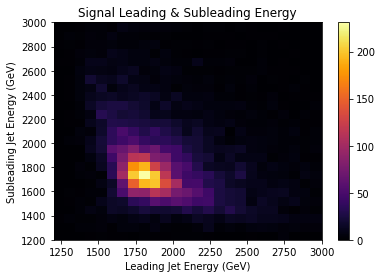

In [16]:
plt.title("Signal Leading & Subleading Energy")
plt.ylabel("Subleading Jet Energy (GeV)")
plt.xlabel("Leading Jet Energy (GeV)")
plt.hist2d(s_lead_e, s_sublead_e, bins = 25, range = [[1200,3000],[1200,3000]], cmap = 'inferno')
plt.colorbar()
plt.show()

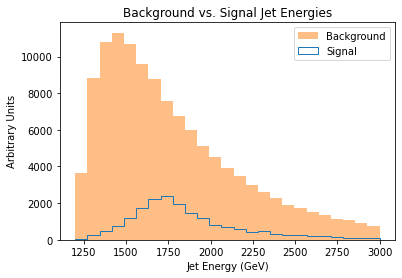

In [17]:
plt.title("Background vs. Signal Jet Energies")
plt.ylabel("Arbitrary Units")
plt.xlabel("Jet Energy (GeV)")
plt.hist(bg_lead_e + bg_sublead_e, bins = 25, range = (1200, 3000), color = "tab:orange", alpha = 0.5, label = "Background")
plt.hist(s_sublead_e + s_sublead_e, bins = 25, range = (1200, 3000), color = "tab:blue", histtype = "step", label = "Signal")
plt.legend()
plt.show()

### More Advanced Exercise: Event Mass & Energy
Access the jet cartesian momenta by calling the attributes `.px`, `.py`, and `.pz`. Add the four-momenta of the corresponding leading and subleading jets; that is, add their respective `e`, `px`, `py`, and `pz`. You now have the four-momentum for the event!

Plot the distribution of the event energy and event mass. (Hint: event mass can be computed from the relation E^2 = m^2 + px^2 + py^2 + pz^2. Remember that c = 1 in particle physics.)

In [18]:
bg_lead_px = [leadjets['bg'][x].px for x in range(len(leadjets['bg']))]
bg_sublead_px = [subleadjets['bg'][x].px for x in range(len(subleadjets['bg']))]
s_lead_px = [leadjets['s'][x].px for x in range(len(leadjets['s']))]
s_sublead_px = [subleadjets['s'][x].px for x in range(len(subleadjets['s']))]

bg_lead_py = [leadjets['bg'][x].py for x in range(len(leadjets['bg']))]
bg_sublead_py = [subleadjets['bg'][x].py for x in range(len(subleadjets['bg']))]
s_lead_py = [leadjets['s'][x].py for x in range(len(leadjets['s']))]
s_sublead_py = [subleadjets['s'][x].py for x in range(len(subleadjets['s']))]

bg_lead_pz = [leadjets['bg'][x].pz for x in range(len(leadjets['bg']))]
bg_sublead_pz = [subleadjets['bg'][x].pz for x in range(len(subleadjets['bg']))]
s_lead_pz = [leadjets['s'][x].pz for x in range(len(leadjets['s']))]
s_sublead_pz = [subleadjets['s'][x].pz for x in range(len(subleadjets['s']))]

bg_lead_e_np = np.array(bg_lead_e)
bg_lead_px_np = np.array(bg_lead_px)
bg_lead_py_np = np.array(bg_lead_py)
bg_lead_pz_np = np.array(bg_lead_pz)
bg_sublead_e_np = np.array(bg_sublead_e)
bg_sublead_px_np = np.array(bg_sublead_px)
bg_sublead_py_np = np.array(bg_sublead_py)
bg_sublead_pz_np = np.array(bg_sublead_pz)

s_lead_e_np = np.array(s_lead_e)
s_lead_px_np = np.array(s_lead_px)
s_lead_py_np = np.array(s_lead_py)
s_lead_pz_np = np.array(s_lead_pz)
s_sublead_e_np = np.array(s_sublead_e)
s_sublead_px_np = np.array(s_sublead_px)
s_sublead_py_np = np.array(s_sublead_py)
s_sublead_pz_np = np.array(s_sublead_pz)

In [19]:
bg_e_np = bg_lead_e_np + bg_sublead_e_np
bg_px_np = bg_lead_px_np + bg_sublead_px_np
bg_py_np = bg_lead_py_np + bg_sublead_py_np
bg_pz_np = bg_lead_pz_np + bg_sublead_pz_np
s_e_np = s_lead_e_np + s_sublead_e_np
s_px_np = s_lead_px_np + s_sublead_px_np
s_py_np = s_lead_py_np + s_sublead_py_np
s_pz_np = s_lead_pz_np + s_sublead_pz_np

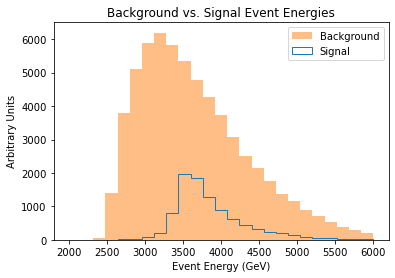

In [20]:
plt.title("Background vs. Signal Event Energies")
plt.ylabel("Arbitrary Units")
plt.xlabel("Event Energy (GeV)")
plt.hist(bg_e_np, bins = 25, range = (2000, 6000), color = "tab:orange", alpha = 0.5, label = "Background")
plt.hist(s_e_np, bins = 25, range = (2000, 6000), color = "tab:blue", histtype = "step", label = "Signal")
plt.legend()
plt.show()

In [21]:
bg_m_np = (bg_e_np**2 - bg_px_np**2 - bg_py_np**2 - bg_pz_np**2)**0.5
s_m_np = (s_e_np**2 - s_px_np**2 - s_py_np**2 - s_pz_np**2)**0.5

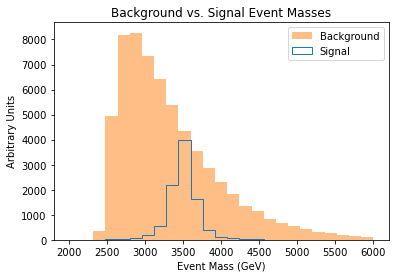

In [22]:
plt.title("Background vs. Signal Event Masses")
plt.ylabel("Arbitrary Units")
plt.xlabel("Event Mass (GeV)")
plt.hist(bg_m_np, bins = 25, range = (2000, 6000), color = "tab:orange", alpha = 0.5, label = "Background")
plt.hist(s_m_np, bins = 25, range = (2000, 6000), color = "tab:blue", histtype = "step", label = "Signal")
plt.legend()
plt.show()

### N-Subjettiness
[N-Subjettiness](https://arxiv.org/abs/1011.2268) is a high-level feature that we use to distinguish the prongs in a jet substructure.

The N-subjettiness, where N is a natural number, is defined as follows:

![N-Subjettiness](N-Subjettiness.png)


In [23]:
# Find the distance between two events in eta-phi space. Note that the distance between phi is subject to the symmetry phi = phi + 2pi, so absolute values are used to ensure proper behavior on edge cases.

def deltaR(j1, j2):
    dEta2 = (j1.eta - j2.eta)**2
    dPhi2 = (np.pi + abs(abs(j1.phi - j2.phi) - np.pi))**2
    return (dEta2 + dPhi2)**0.5

# Compute N-Subjettiness

def tau(N, jet):
    sequence = cluster(jet, R = 1.0, p = -1)
    try:
        jets = sequence.exclusive_jets(N)
    except:
        return -1
    if len(jets) < N:
        return -1
    out = 0
    d0 = 0
    consts = []
    for i in range(N):
        consts += jets[i].constituents()
    for i in range(len(consts)):
        d0 += consts[i].pt
        R = deltaR(consts[i], jets[0])
        for j in range(N):
            R = min(R, deltaR(consts[i], jets[j]))
        out += consts[i].pt * R
    return out / d0

# Compute ratio of N-Subjettiness. Here, we compute tau2/tau1 to gauge the 2-prong substructure of the signal event.

def tau21(jet):
    tau2 = tau(2, jet)
    tau1 = tau(1, jet)
    if tau2 == -1 or tau1 == -1:
        return -1
    return tau2 / tau1

def tau32(jet):
    tau3 = tau(3, jet)
    tau2 = tau(2, jet)
    if tau3 == -1 or tau2 == -1:
        return -1
    return tau3 / tau2

In [24]:
# Compute all the tau ratios

tau21_bg_lead = [tau21(leadjets['bg'][x]) for x in range(len(leadjets['bg'])) if tau21(leadjets['bg'][x]) != -1]
tau21_bg_sublead = [tau21(subleadjets['bg'][x]) for x in range(len(subleadjets['bg'])) if tau21(subleadjets['bg'][x]) != -1]
tau21_s_lead = [tau21(leadjets['s'][x]) for x in range(len(leadjets['s'])) if tau21(leadjets['s'][x]) != -1]
tau21_s_sublead = [tau21(subleadjets['s'][x]) for x in range(len(subleadjets['s'])) if tau21(subleadjets['s'][x]) != -1]

tau32_bg_lead = [tau32(leadjets['bg'][x]) for x in range(len(leadjets['bg'])) if tau32(leadjets['bg'][x]) != -1]
tau32_bg_sublead = [tau32(subleadjets['bg'][x]) for x in range(len(subleadjets['bg'])) if tau32(subleadjets['bg'][x]) != -1]
tau32_s_lead = [tau32(leadjets['s'][x]) for x in range(len(leadjets['s'])) if tau32(leadjets['s'][x]) != -1]
tau32_s_sublead = [tau32(subleadjets['s'][x]) for x in range(len(subleadjets['s'])) if tau32(subleadjets['s'][x]) != -1]

In [25]:
tau21_bg = tau21_bg_lead + tau21_bg_sublead
tau21_s = tau21_s_lead + tau21_s_sublead

tau32_bg = tau32_bg_lead + tau32_bg_sublead
tau32_s = tau32_s_lead + tau32_s_sublead

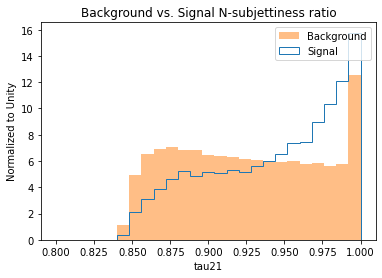

In [26]:
# This should be the discriminating statistic for the two-prong substructure

plt.title("Background vs. Signal N-subjettiness ratio")
plt.ylabel("Normalized to Unity")
plt.xlabel("tau21")
plt.hist(tau21_bg, bins = 25, range = (0.8, 1), color = "tab:orange", alpha = 0.5, label = "Background", density = True)
plt.hist(tau21_s, bins = 25, range = (0.8, 1), color = "tab:blue", histtype = "step", label = "Signal", density = True)
plt.legend()
plt.show()

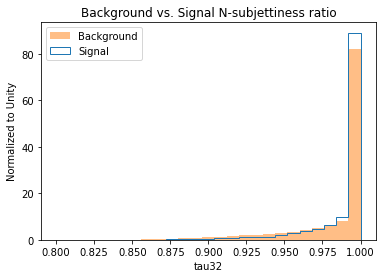

In [27]:
# This statistic shouldn't be very interesting because the substructure is 2-prong not 3-prong

plt.title("Background vs. Signal N-subjettiness ratio")
plt.ylabel("Normalized to Unity")
plt.xlabel("tau32")
plt.hist(tau32_bg, bins = 25, range = (0.8, 1), color = "tab:orange", alpha = 0.5, label = "Background", density = True)
plt.hist(tau32_s, bins = 25, range = (0.8, 1), color = "tab:blue", histtype = "step", label = "Signal", density = True)
plt.legend()
plt.show()

## 4. Exercise
Now it's your turn! Do the data preprocessing and feature study, as we've done in this tutorial, using the file `events_anomalydetection_Z_XY_qqq.h5`, which you should download at the same [Zenodo link](https://zenodo.org/record/3832254#.X9VNZdhKguU). Note a few key differences:
* This file only has 100k signal events and no background
* Therefore, there is no signal bit column
* The signal has 3-prong substructure, so the proper N-subjetiness ratio to compute is tau3/tau2 instead of tau2/tau1

In [28]:
# Replace this variable with your relative path to datafile
datapath = "zenodo-data/events_anomalydetection_Z_XY_qqq.h5"

size = 10000
df = pd.read_hdf(datapath, stop = size) # The amount of data loaded can be changed depending on your hardware capabilities
print("Shape: " + str(df.shape))
print("Memory usage in GB:", round(sum(df.memory_usage(deep=True)) / (1024**3), 3))

Shape: (10000, 2101)
Memory usage in GB: 0.157


In [29]:
# Observe the following about the data:
# pT columns are always positive
# Zero-padding is evident at the end
# There is no signal column, because all rows are signal
df

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,18.283588,-0.903479,0.060979,3.316431,-0.784941,-0.008755,9.464178,-0.812918,-0.037386,4.578035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,17.661003,-0.446288,-1.379160,43.478683,-0.458125,-1.373650,208.452606,-0.455308,-1.375457,99.440353,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.624793,-0.677988,0.938955,1.265689,-1.418007,-2.987415,2.943629,-1.171538,2.927404,1.740146,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.337102,-0.576148,-1.488119,0.746461,-0.690281,-1.168585,0.822929,-0.611731,-0.854227,1.700466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.560168,-0.426791,0.971822,0.522985,-2.214125,0.120384,1.950790,-2.105558,-0.649089,0.402474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.672274,-0.941399,-0.564204,0.492193,-0.828246,1.192775,0.414573,-1.430574,-0.668218,0.630515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9996,2.195669,-1.299108,-0.566588,1.696192,-1.168087,-0.481458,3.508357,-0.966948,-0.396851,2.556466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9997,0.811707,-2.256791,0.002384,0.648878,-1.069699,2.485933,1.201116,0.165013,-0.817953,5.445698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9998,0.417859,-2.310305,-2.973123,0.469332,-1.282014,-3.113041,1.010556,-1.161570,3.037749,1.249739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
print("Signal shape: " + str(df.shape))

Signal shape: (10000, 2101)


In [31]:
# Transposing df makes rows correspond to low-level features and columns correspond to events
events = df.T

In [32]:
def cluster_jets(dataframe, lead = True):
    leading = []
    subleading = []
    for i in tqdm(range(dataframe.shape[1])):
        # Collect (pT,eta,phi) of particles in event i with pT != 0
        pseudojets_input = np.zeros(len([x for x in dataframe[i][::3] if x > 0]), dtype = DTYPE_PTEPM)
        for j in range(700):
            if dataframe[i][j*3] > 0:
                pseudojets_input[j]['pT'] = dataframe[i][j*3]
                pseudojets_input[j]['eta'] = dataframe[i][j*3 + 1]
                pseudojets_input[j]['phi'] = dataframe[i][j*3 + 2]
            else:
                break

        sequence = cluster(pseudojets_input, R = 1.0, p = -1) # p = -1 corresponds to anti-kT
        jets = sequence.inclusive_jets(ptmin = 1200) # pT > 1.2 TeV

        if len(jets) < 2:
            continue
        
        leading += [jets[0]]
        subleading += [jets[1]]
    if lead:
        return leading
    return subleading

In [33]:
leadjets = cluster_jets(events, True)
subleadjets = cluster_jets(events, False)

100%|██████████| 10000/10000 [01:01<00:00, 162.51it/s]


In [34]:
print("Leading jets:", len(leadjets))
print("Subleading jets:", len(subleadjets))
print("Events not clustered:", size - len(leadjets))

Leading jets: 9482
Subleading jets: 9482
Events not clustered: 518


In [35]:
lead_mass = [leadjets[x].mass for x in range(len(leadjets))]
sublead_mass = [subleadjets[x].mass for x in range(len(subleadjets))]

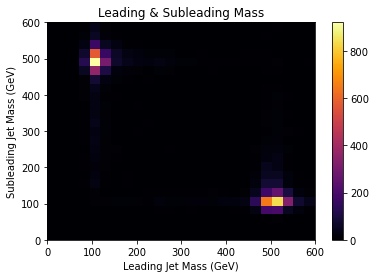

In [36]:
plt.title("Leading & Subleading Mass")
plt.ylabel("Subleading Jet Mass (GeV)")
plt.xlabel("Leading Jet Mass (GeV)")
plt.hist2d(lead_mass, sublead_mass, bins = 25, range = [[0,600],[0,600]], cmap = 'inferno')
plt.colorbar()
plt.show()

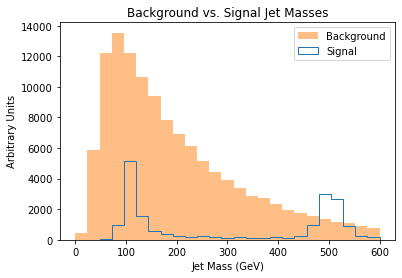

In [37]:
plt.title("Background vs. Signal Jet Masses")
plt.ylabel("Arbitrary Units")
plt.xlabel("Jet Mass (GeV)")
plt.hist(bg_lead_mass + bg_sublead_mass, bins = 25, range = (0, 600), color = "tab:orange", alpha = 0.5, label = "Background")
plt.hist(lead_mass + sublead_mass, bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "Signal")
plt.legend()
plt.show()

In [38]:
lead_e = [leadjets[x].e for x in range(len(leadjets))]
sublead_e = [subleadjets[x].e for x in range(len(subleadjets))]

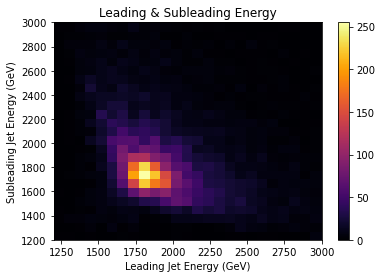

In [39]:
plt.title("Leading & Subleading Energy")
plt.ylabel("Subleading Jet Energy (GeV)")
plt.xlabel("Leading Jet Energy (GeV)")
plt.hist2d(lead_e, sublead_e, bins = 25, range = [[1200,3000],[1200,3000]], cmap = 'inferno')
plt.colorbar()
plt.show()

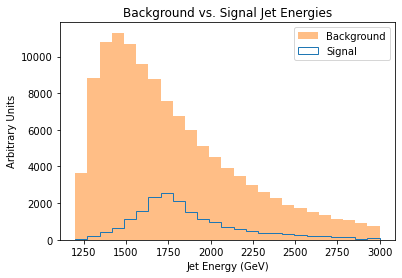

In [40]:
plt.title("Background vs. Signal Jet Energies")
plt.ylabel("Arbitrary Units")
plt.xlabel("Jet Energy (GeV)")
plt.hist(bg_lead_e + bg_sublead_e, bins = 25, range = (1200, 3000), color = "tab:orange", alpha = 0.5, label = "Background")
plt.hist(sublead_e + sublead_e, bins = 25, range = (1200, 3000), color = "tab:blue", histtype = "step", label = "Signal")
plt.legend()
plt.show()

In [41]:
lead_px = [leadjets[x].px for x in range(len(leadjets))]
sublead_px = [subleadjets[x].px for x in range(len(subleadjets))]

lead_py = [leadjets[x].py for x in range(len(leadjets))]
sublead_py = [subleadjets[x].py for x in range(len(subleadjets))]

lead_pz = [leadjets[x].pz for x in range(len(leadjets))]
sublead_pz = [subleadjets[x].pz for x in range(len(subleadjets))]

lead_e_np = np.array(lead_e)
lead_px_np = np.array(lead_px)
lead_py_np = np.array(lead_py)
lead_pz_np = np.array(lead_pz)
sublead_e_np = np.array(sublead_e)
sublead_px_np = np.array(sublead_px)
sublead_py_np = np.array(sublead_py)
sublead_pz_np = np.array(sublead_pz)

In [42]:
e_np = lead_e_np + sublead_e_np
px_np = lead_px_np + sublead_px_np
py_np = lead_py_np + sublead_py_np
pz_np = lead_pz_np + sublead_pz_np

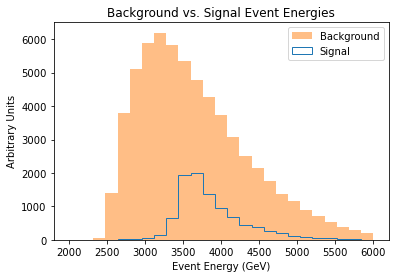

In [43]:
plt.title("Background vs. Signal Event Energies")
plt.ylabel("Arbitrary Units")
plt.xlabel("Event Energy (GeV)")
plt.hist(bg_e_np, bins = 25, range = (2000, 6000), color = "tab:orange", alpha = 0.5, label = "Background")
plt.hist(e_np, bins = 25, range = (2000, 6000), color = "tab:blue", histtype = "step", label = "Signal")
plt.legend()
plt.show()

In [44]:
m_np = (e_np**2 - px_np**2 - py_np**2 - pz_np**2)**0.5

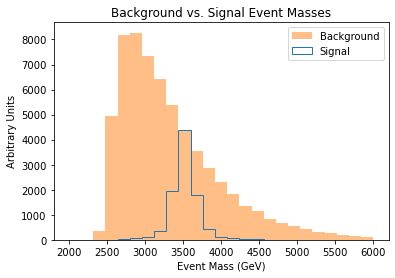

In [45]:
plt.title("Background vs. Signal Event Masses")
plt.ylabel("Arbitrary Units")
plt.xlabel("Event Mass (GeV)")
plt.hist(bg_m_np, bins = 25, range = (2000, 6000), color = "tab:orange", alpha = 0.5, label = "Background")
plt.hist(m_np, bins = 25, range = (2000, 6000), color = "tab:blue", histtype = "step", label = "Signal")
plt.legend()
plt.show()

In [46]:
# Find the distance between two events in eta-phi space. Note that the distance between phi is subject to the symmetry phi = phi + 2pi, so absolute values are used to ensure proper behavior on edge cases.

def deltaR(j1, j2):
    dEta2 = (j1.eta - j2.eta)**2
    dPhi2 = (np.pi + abs(abs(j1.phi - j2.phi) - np.pi))**2
    return (dEta2 + dPhi2)**0.5

# Compute N-Subjettiness

def tau(N, jet):
    sequence = cluster(jet, R = 1.0, p = -1)
    try:
        jets = sequence.exclusive_jets(N)
    except:
        return -1
    if len(jets) < N:
        return -1
    out = 0
    d0 = 0
    consts = []
    for i in range(N):
        consts += jets[i].constituents()
    for i in range(len(consts)):
        d0 += consts[i].pt
        R = deltaR(consts[i], jets[0])
        for j in range(N):
            R = min(R, deltaR(consts[i], jets[j]))
        out += consts[i].pt * R
    return out / d0

# Compute ratio of N-Subjettiness. Here, we compute tau3/tau2 to gauge the 3-prong substructure of the signal event.

def tau21(jet):
    tau2 = tau(2, jet)
    tau1 = tau(1, jet)
    if tau2 == - 1 or tau1 == -1:
        return -1
    return tau2 / tau1

def tau32(jet):
    tau3 = tau(3, jet)
    tau2 = tau(2, jet)
    if tau3 == -1 or tau2 == -1:
        return -1
    return tau3 / tau2

In [47]:
# Compute all the tau ratios

tau21_lead = [tau21(leadjets[x]) for x in range(len(leadjets)) if tau21(leadjets[x]) != -1]
tau21_sublead = [tau21(subleadjets[x]) for x in range(len(subleadjets)) if tau21(subleadjets[x]) != -1]

tau32_lead = [tau32(leadjets[x]) for x in range(len(leadjets)) if tau32(leadjets[x]) != -1]
tau32_sublead = [tau32(subleadjets[x]) for x in range(len(subleadjets)) if tau32(subleadjets[x]) != -1]

In [48]:
tau21 = tau21_lead + tau21_sublead
tau32 = tau32_lead + tau32_sublead

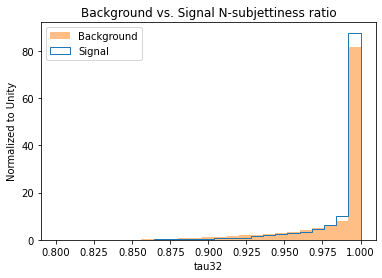

In [49]:
# This should be the discriminating statistic for the three-prong substructure

plt.title("Background vs. Signal N-subjettiness ratio")
plt.ylabel("Normalized to Unity")
plt.xlabel("tau32")
plt.hist(tau32_bg, bins = 25, range = (0.8, 1), color = "tab:orange", alpha = 0.5, label = "Background", density = True)
plt.hist(tau32, bins = 25, range = (0.8, 1), color = "tab:blue", histtype = "step", label = "Signal", density = True)
plt.legend()
plt.show()

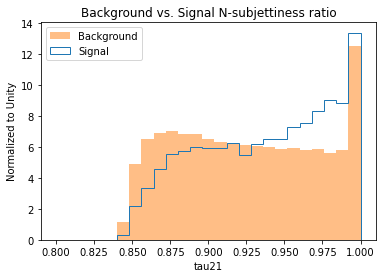

In [50]:
# This statistic shouldn't be very interesting because the substructure is 3-prong not 2-prong

plt.title("Background vs. Signal N-subjettiness ratio")
plt.ylabel("Normalized to Unity")
plt.xlabel("tau21")
plt.hist(tau21_bg, bins = 25, range = (0.8, 1), color = "tab:orange", alpha = 0.5, label = "Background", density = True)
plt.hist(tau21, bins = 25, range = (0.8, 1), color = "tab:blue", histtype = "step", label = "Signal", density = True)
plt.legend()
plt.show()